<a href="https://colab.research.google.com/github/chabazite/HOML_practice/blob/main/03_classifiers_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.datasets import fetch_openml
#setting frame as false, stops sklearn from setting up a Pandas DataFrame and uses numpy instead
mnist = fetch_openml('mnist_784', as_frame=False)

OpenMLError: Dataset with data_id 554 not found.

In [ ]:

X, y = mnist['data'], mnist['target']

In [ ]:
X.shape

(70000, 784)

In [ ]:
y.shape

(70000,)

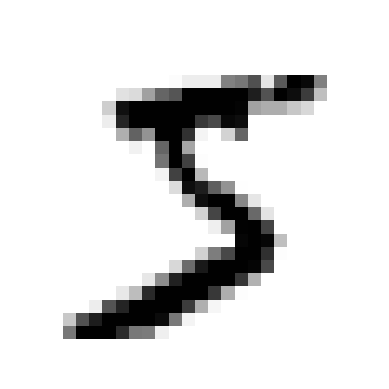

In [ ]:
# 28 x 28 pixels, each feature simply represents one pixels intensity from 0 to 255
import matplotlib.pyplot as plt

def plot_digit(image_data):
  image = image_data.reshape(28,28)
  plt.imshow(image, cmap="binary")
  plt.axis('off')

some_digit = X[0]

plot_digit(some_digit)
plt.show()

In [ ]:
# data is already shuffled, so let's break it into train and test

X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000], y[60_000:]

## Training A Binary Classifier

In [ ]:
# digit 5 or not
y_train_5 = (y_train=="5")
y_test_5 = (y_test=="5")

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([some_digit])

array([ True])

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [ ]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [ ]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

This is why we don't use accuracy for classification problems

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)

cm

array([[53892,   687],
       [ 1891,  3530]])

In [ ]:
y_train_perfect_predictions = y_train_5 # pretending we get perfect predictions to show perfect CM

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [ ]:
# Looks like we only get it right 83% of the time, and we only detect 65% of the 5s

In [ ]:
# Let's change the decision threshold to see if we can get a better recall
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [ ]:
# starting threshold
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [ ]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [ ]:
# get all the decision scores of all the instances
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = "decision_function")

In [ ]:
# plot precision recall curve
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

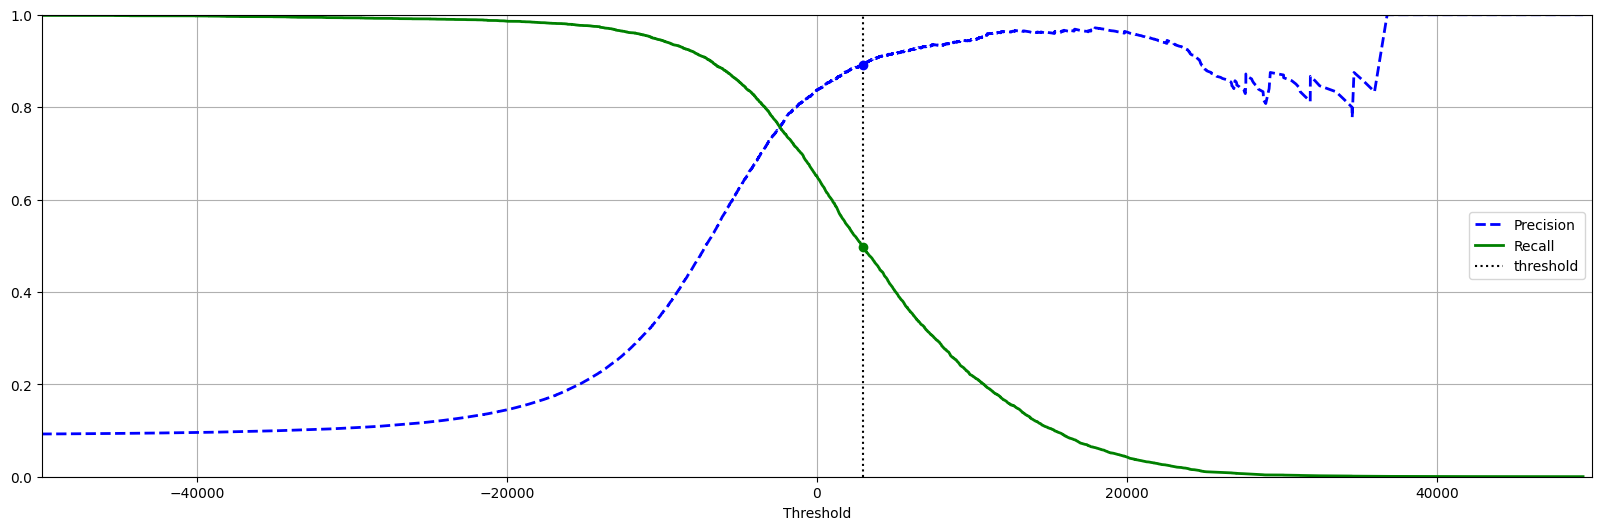

In [ ]:
plt.figure(figsize=(20, 6))

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0,1.0, "k", 'dotted', label = "threshold")

idx = (thresholds >= threshold).argmax()
plt.plot(thresholds[idx], precisions[idx], 'bo')
plt.plot(thresholds[idx], recalls[idx], 'go')
plt.axis([-50_000,50_000,0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

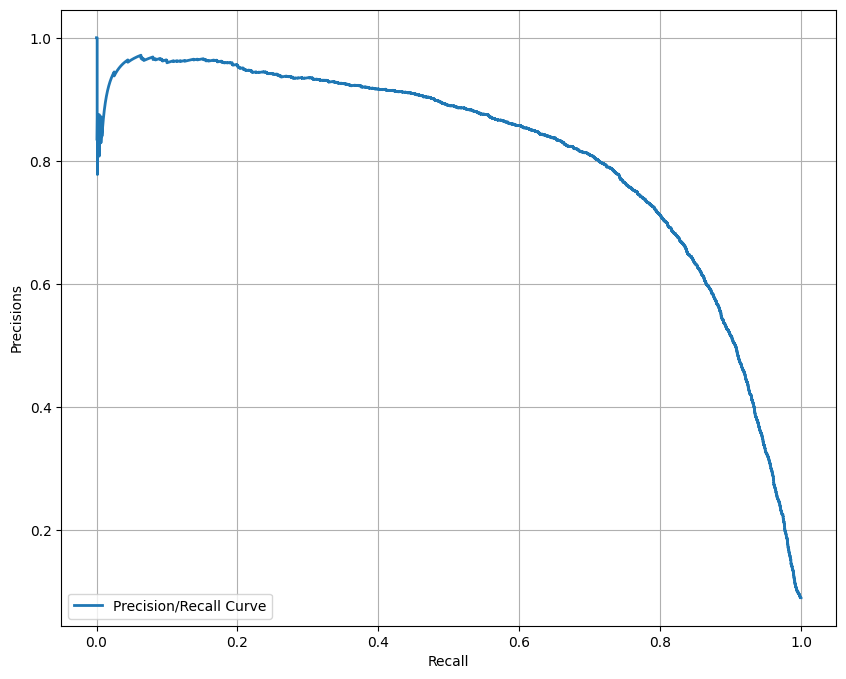

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall Curve")
plt.grid()
plt.xlabel('Recall')
plt.ylabel('Precisions')
plt.legend(loc='lower left')
plt.show()

In [ ]:
# assuming we want to aim at 90% precision (50% recall)
idx_for_90_precisions = (precisions >= 0.9).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precisions]

threshold_for_90_precision

3370.0194991439557

In [ ]:
# to make predictions , you can run a threshold comparision rather than running predict() with the new threshold
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [ ]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [ ]:
recall_score(y_train_5, y_train_pred_90)


0.4799852425751706

In [ ]:
# ROC curve -> true posistive vs false positive rate
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [ ]:
(thresholds <= threshold_for_90_precision)

array([False, False, False, ...,  True,  True,  True])

In [ ]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax() # less than because its listed in descending order this case

In [ ]:
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

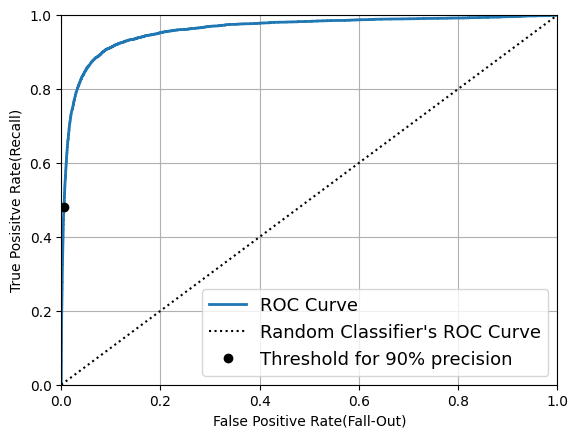

In [ ]:
# While our goal was @90% precision, usually with tradeoff you want to be as far away from the 'random ROC curve' as possible, which maximizes both Precision and Recall
plt.plot(fpr, tpr, linewidth=2, label="ROC Curve")
plt.plot([0,1],[0,1],'k:', label = "Random Classifier's ROC Curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

plt.ylabel('True Posisitve Rate(Recall)')
plt.xlabel('False Positive Rate(Fall-Out)')
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower right", fontsize=13)
plt.show()

In [ ]:
# Measure the AUC (Area under the Curve)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

## Create RandomForest Classifier to Compare A

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [ ]:
# there is no decision function here, so we will need to use predict_proba() instead, even though it isn't calibrated

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [ ]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [ ]:
# second column contains estimated probabilities for the positive class
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

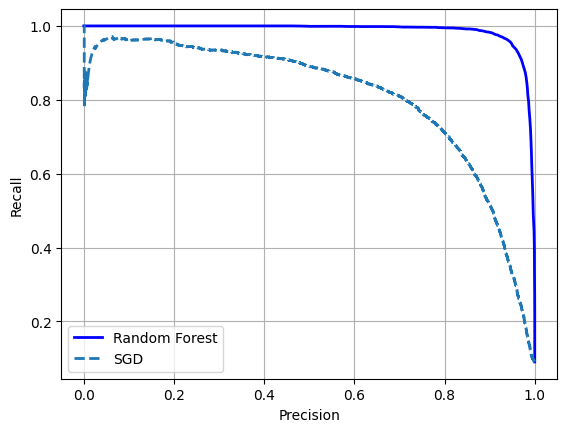

In [ ]:
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label='Random Forest')
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.grid()
plt.legend(loc='lower left')
plt.xlabel('Precision')
plt.ylabel("Recall")
plt.show()

As we can see., the random forest curve looks WAY better than the SGD curve

In [ ]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5 # positive probas is >=50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

Both F1 scores and ROC AUC scores are better for the Random Forest, How is the PR_scores

In [ ]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [ ]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

## Multiclass Classification
The MNist dataset is actually a multiclass problem though. Lets build a classifier that can interpret and assign one of many different classes

In [ ]:
from sklearn.svm import SVC
# support vector machines are very straight forward and should automatically train multiple classifiers for us either as OvO or OvR (OvA)

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000],y_train[:2000]) # start with a smaller dataset as SVC doesn't do well with large data (memory-intensive)

SVC(random_state=42)

In [ ]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [ ]:
# lets see how many predictions it made to come to this conclusion

some_digit_predictions = svm_clf.decision_function([some_digit])

In [ ]:
# There are 10 predictions here  (one for each class)
some_digit_predictions.round(2)
# each class gets a score of number of won dules plus or minus a smal tweak to break ties

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [ ]:
# Lets force it do do a OneVsRestClassifier by wrapping around the SVC
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [ ]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [ ]:
len(ovr_clf.estimators_)

10

In [ ]:
# Train SGD the same way
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [ ]:
# It trained using OvR, which is 10 binary classifiers, decision function returns one value per class
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [ ]:
# if you used a random classifier you would get 10% accuracy, what do we get here?
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
# scaling inputs is important for gradiant descent
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring = 'accuracy')

array([0.8983, 0.891 , 0.9018])

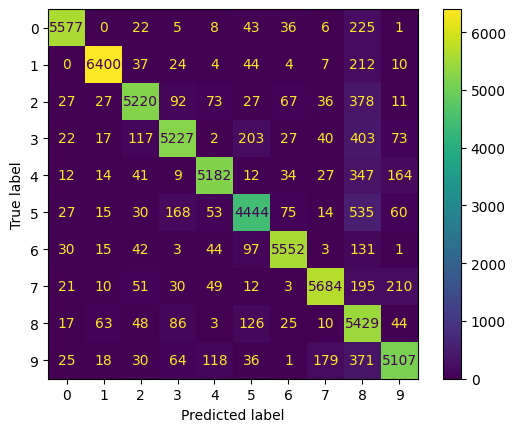

In [ ]:
# Let's analyze the errors made!
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

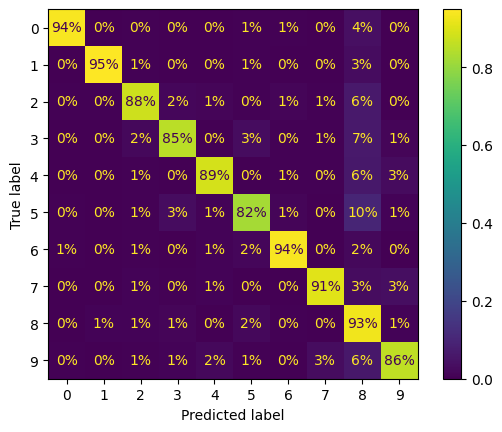

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize='true',values_format=".0%")
plt.show()

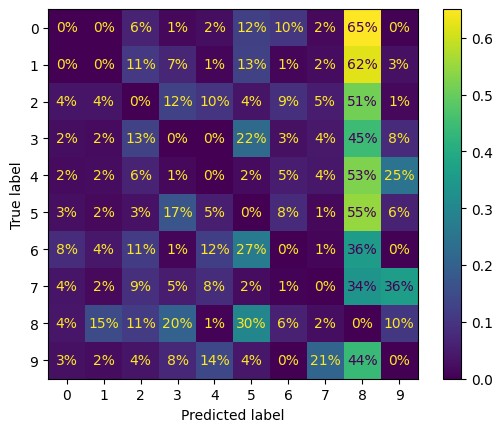

In [ ]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize='true', values_format='.0%')

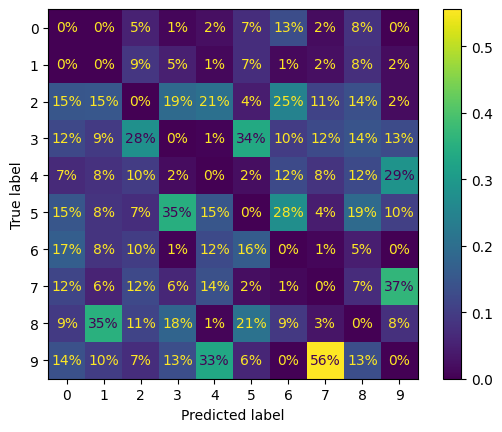

In [ ]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize='pred', values_format='.0%')

In [ ]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

ValueError: too many values to unpack (expected 2)

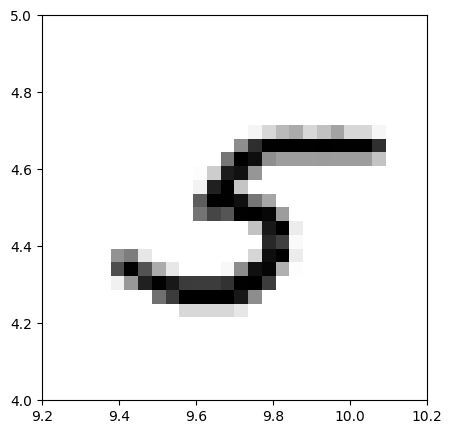

In [ ]:
size = 5
pad = 0.2
plt.figure(figsize=(size,size))
for images, (label_col, label_row) in [(X_ba, (0,0)), (X_bb, (1,0)),
                                       (X_aa, (0,1), (X_ab, (1,1)))]:
    for idx, image_data in enumerate(images[:size*size]):
      x = idx % size + label_col * (size + pad)
      y = idx // size + label_row * (size + pad)
      plt.imshow(image_data.reshape(28,28), cmap='binary',
                 extent=(x,x+1, y, y+1))

plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
save_fig("error_analysis_digits_plot")
plt.show()

## Multilabel Classification

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large =(y_train >= '7')
y_train_odd = (y_train.astype('int8') %  2 == 1)
y_multilabel = np.c_[y_train_large,y_train_odd]

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

YOU CAN EVEN USE MULTI LABELS IN A CHAIN. This will help inform other labels.
For example, a large number 7-9 is twice as more likely to be odd than even. So that would help inform the odd label

- ClassifierChain - default it will use the true labels for training, feedng each model the appropriate labels depending on their position in the chain
  - if you set the cv hyperparameter, it uses cross-validation to get "clean" predictions from each trained model for every instance in the training set, and these predictions will then be used to train all the models later in the chain.

In [ ]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

chain_clf.predict([some_digit])

array([[0., 1.]])

## Multioutput-multiclass
- generalization of multilabel where each labelcan be multiclass

In [ ]:
# Build a system that removes noise from our images. Take a messy image and hopefully clean it up and present a nice output image
## the classifiers output is multilabel (one label per pixel) and each lavbel can have multiple values (pixel intensity ranges from 0 to 255) multi class

# create training and test sets and add noise to pixel intensities
np.random.seed(42) # to make this code example reproducible
noise = np.random.randint(0,100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test


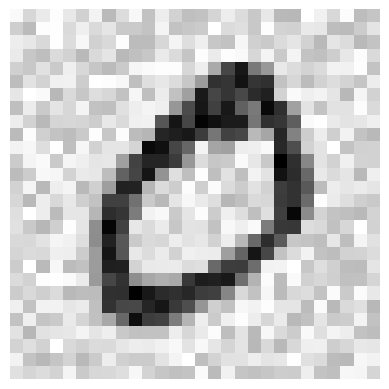

In [ ]:
mod_digit = X_train_mod[1]
plot_digit(mod_digit)
plt.show()



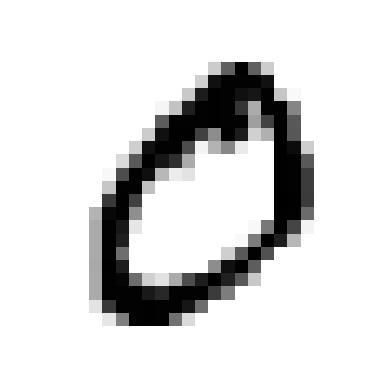

In [ ]:
mod_digit_clean = X_train[1]
plot_digit(mod_digit_clean)
plt.show()



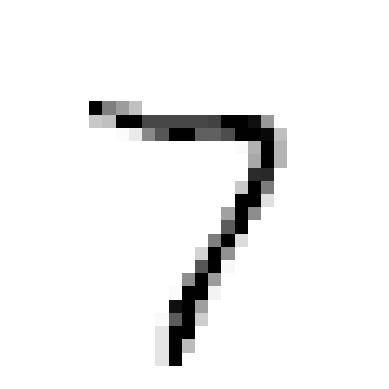

In [ ]:
knn_clf = KNeighborsClassifier()

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()

That looks pretty darn clean!

## Extra Excercises

### 1) Build a Classifier that achieves over 97% accuracy on the test set.

In [1]:
from scipy.stats import randint
import numpy as np
from sklearn.model_selection import  RandomizedSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score, accuracy_score
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

In [2]:
#setting frame as false, stops sklearn from setting up a Pandas DataFrame and uses numpy instead
mnist = fetch_openml('mnist_784', as_frame=False)

In [3]:
X, y = mnist['data'], mnist['target']
X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000], y[60_000:]

In [4]:
knn_clf = KNeighborsClassifier()

knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)

In [5]:
accuracy_score(y_pred, y_test)

0.9688

In [6]:
# We are going to tune hyperparameters, which means we need a validation set

When using metric="precomputed", Scikit-learn expects the input X_train to be a distance or similarity matrix (i.e., a square matrix with shape (n_samples, n_samples)). However, you are passing raw features, which causes the error.

In [8]:

param_dist = {
    "n_neighbors" : randint(low = 1, high = 10),
    "weights": ['uniform', 'distance'],
    "metric": ["minkowski", "manhattan", 'cosine'],
    "algorithm": ['auto', "ball_tree", "kd_tree","brute"]
}
knn_clf = KNeighborsClassifier()
rnd_search = RandomizedSearchCV(knn_clf, param_distributions = param_dist, n_iter = 10, cv =3, scoring = 'accuracy', random_state =42)

rnd_search.fit(X_train[:10_000], y_train[:10_000])

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
9 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 238, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.10/dist-packages/s

RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(),
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'metric': ['minkowski', 'manhattan',
                                                   'cosine'],
                                        'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7acf72de66b0>,
                                        'weights': ['uniform', 'distance']},
                   random_state=42, scoring='accuracy')

In [9]:
rnd_search.best_params_

{'algorithm': 'auto',
 'metric': 'cosine',
 'n_neighbors': 3,
 'weights': 'uniform'}

In [7]:
knn_clf = KNeighborsClassifier(n_neighbors = 3 , weights = 'uniform' , metric = 'cosine', algorithm = 'auto')

knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)

In [52]:
tuned_accuracy = accuracy_score(y_pred, y_test)

### Question 2: Data Augmentation
- Write a function to shift an MNIST image in any direciton
  -  left,right, up, down by one pixel.
  - for each image in training set, add four shifted copies (one per direction)
  - Train best model on this expanded training set and measure its accuracy on data augmentation

In [27]:
def image_translation(image, direction):
  """
  We have a 28 x 28 pixel image, we want to shift it in a chosen direction.
  This is a 1D array, so we need to adjust it so be a 2D array for easy movemetn
  then either the first or last row/column
  in the internal array in order to make the entire image shift.
  """

  if direction in ['left','right']:
    # reform array so columns are second level array
    image_col = image.reshape(28, 28).T

    if direction == 'left':
      # move the first column to the last column
      image_col = np.vstack([image_col[1:],image_col[0]])
    elif direction == 'right':
      # move the last column to the first column
      image_col = np.vstack([[image_col[-1]],image_col[:-1]])

    #return to 1D array with correct orientation
    altered_image = image_col.T.flatten()

  elif direction in ['up','down']:
    #reform so rows are second level array
    image_row = image.reshape(28, 28)
    if direction == 'up':
      # move the first row to the last row
      image_row = np.vstack([image_row[1:],image_row[0]])
    elif direction == 'down':
      # move the last row to the first row
      image_row = np.vstack([image_row[-1],image_row[:-1]])

    #return to 1D array
    altered_image = image_row.flatten()
  else:
    return print('not a direction')

  return altered_image

Ok, so my code works, but apparently there is a cool easy method build in from scipy. Let's use it
- My code I'm realizing doesn't create a black row, it would put the row that normally would be off the screen in place of that black row or column (not the best solution)

In [31]:
from scipy.ndimage import shift
# This method allows for a few different types of shift modes like mirror or wrap.
# Constant is default and fill in with cval

In [33]:
def shift_image(image, dx, dy):
  '''
  This reshapes the image to a 2D array like my function before, in order to translate the inner arrays
  Then it uses the shift method with the image, two cordinates for where to shift it (either in the x or y direction (or both if needed))
  Then it flattens the image
  '''
  image = image.reshape((28, 28))
  shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
  return shifted_image.reshape([-1])

In [41]:
def print_image(image):
  plt.figure(figsize=(12, 3))
  plt.imshow(image.reshape((28, 28)))
  plt.show()

In [34]:
# create our new dataset lists
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

# apply the shift function for each set of shifting cordinates (move left (-1 pixel), move right (+1 pixel), move down(+1 pixel), move up(-1 pixel))
for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
    # we want to keep the image and the label together, so the augmented version has the same label
    for image, label in zip(X_train, y_train):
        print(image)
        # create a new image and add a new label as well in the same index
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

# turn them back into arrays
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

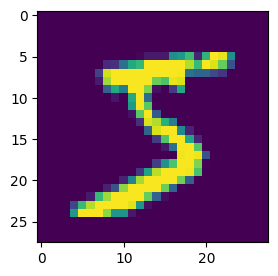

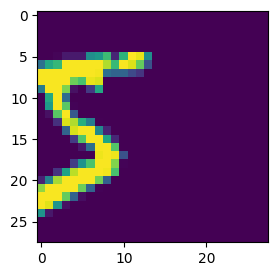

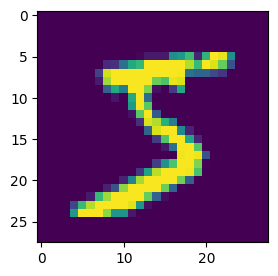

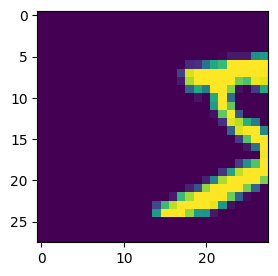

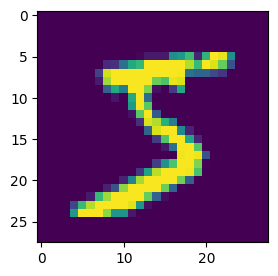

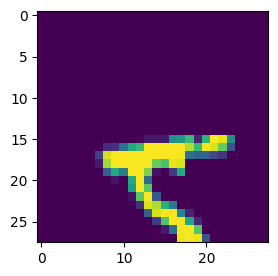

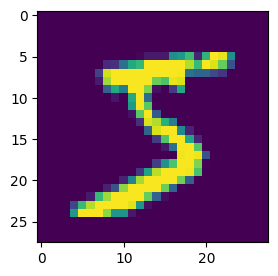

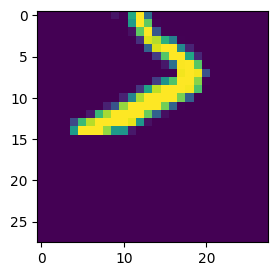

In [46]:

# apply the shift function for each set of shifting cordinates (move left (-1 pixel), move right (+1 pixel), move down(+1 pixel), move up(-1 pixel))
for dx, dy in ((-10, 0), (10, 0), (0, 10), (0, -10)):
    # we want to keep the image and the label together, so the aug version has the same label
    for image, label in zip(X_train[:1], y_train[:1]):
      print_image(image.reshape((28,28)))
      print_image(shift_image(image, dx, dy))

In [47]:
# Shuffle Time
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [49]:
knn_clf = KNeighborsClassifier(n_neighbors = 3 , weights = 'uniform' , metric = 'cosine', algorithm = 'auto')

knn_clf.fit(X_train_augmented, y_train_augmented)
y_pred = knn_clf.predict(X_test)

In [50]:
augmented_accuracy = knn_clf.score(X_test, y_test)
augmented_accuracy

0.9798

In [53]:
error_rate_change = (1 - augmented_accuracy) / (1 - tuned_accuracy) - 1
print(f"error_rate_change = {error_rate_change:.0%}")

error_rate_change = 0%


### Exercise 3: Titantic Dataset
Kaggle has the titanic dataset available.
Goal: Train a classifier that can predict the Survived column based on other columns

In [57]:
!pip install kaggle

In [58]:
! mkdir ~/.kaggle

In [59]:
! cp kaggle.json ~/.kaggle/

In [60]:
! chmod 600 ~/.kaggle/kaggle.json

In [56]:
import opendatasets as od
import pandas as pd

In [ ]:
od.download(
    "https://www.kaggle.com/datasets/\
    muratkokludataset/acoustic-extinguisher-fire-dataset")